## Gaussian Process of Runup at Narrabeen Beach
This notebook includes the development of a GP of runup at Narrabeen Beach. The aim is to develop a GP that is able to paramaterise the calculation of runup as a function of offshore wave height, wave period, and beach slope. The benefit of using a GP to estimate runup is that it provides an estimate of both the mean and standard deviation of runup for particular conditions, and is suited to stochastic parameterisation.

### General Workflow
1. Import pre-prepared .csv file of data
2. Split into train/test sets
3. Standarize data
4. Select kernel/train GP
5. Test GP on withheld data

### Issues
1. Remove bad data. There are plenty of bad datapoints in the data, e.g. bad Tp values. Get rid of them.
2. Split data in train/test sets using random sample or mdl?
3. What kernel to use?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel

plt.rcParams['font.size'] = 18

In [3]:
# Read in data file
df = pd.read_csv('runup_data.csv',parse_dates=True,index_col=0).dropna()
df.head()

,Hs,Tp,slope,runup
time,,,,
2014-05-20 10:00:00,0.538424,10.487102,0.162514,0.819012
2014-05-20 13:00:00,0.687159,9.593233,0.167000,0.882722
2014-05-20 14:00:00,0.655254,9.583498,0.166503,0.885877
2014-05-20 15:00:00,0.526552,10.487527,0.157757,0.854396
2014-05-20 16:00:00,0.543070,10.412249,0.160459,0.845645


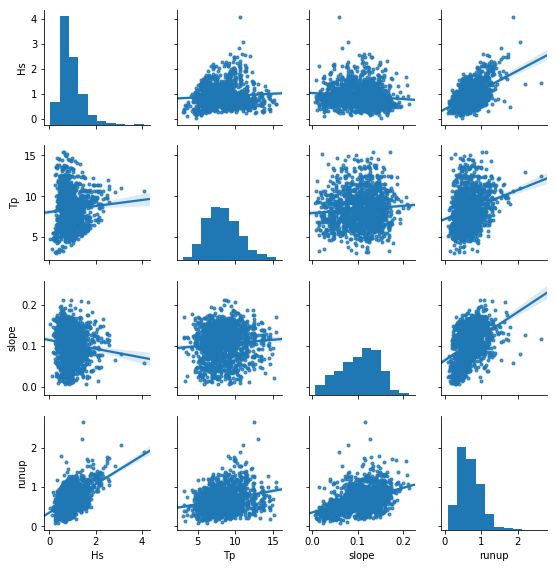

In [4]:
# Data exploration
# Change this two a 2d surface plot on the tril
sns.pairplot(df.sample(round(len(df)/6)),markers='.',kind='reg',size=2)

In [5]:
# Split data into training/testing
X = df.drop(columns='runup')
y = df[['runup']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=121)

In [6]:
# Scale training data and then test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Different Kernel Specification
kernel = Matern(0.1, (1e-2, 1e2), 1.5) + WhiteKernel(1,(1e-2,1e2))
# kernel = Matern(1, (1e-2, 1e2),1.5)
# kernel = DotProduct(1, (1e-2, 1e2))
# kernel = ExpSineSquared()
# kenrel = RationalQuadratic()

In [8]:
# Train GP model
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.3, normalize_y=True, random_state=123)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=123)
gp.fit(X_train_scaled, y_train)
y_pred, sigma = gp.predict(X_test_scaled, return_std=True)

In [9]:
# Evaluate Predictions
print('RMSE =', np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE = 0.1971183192180694


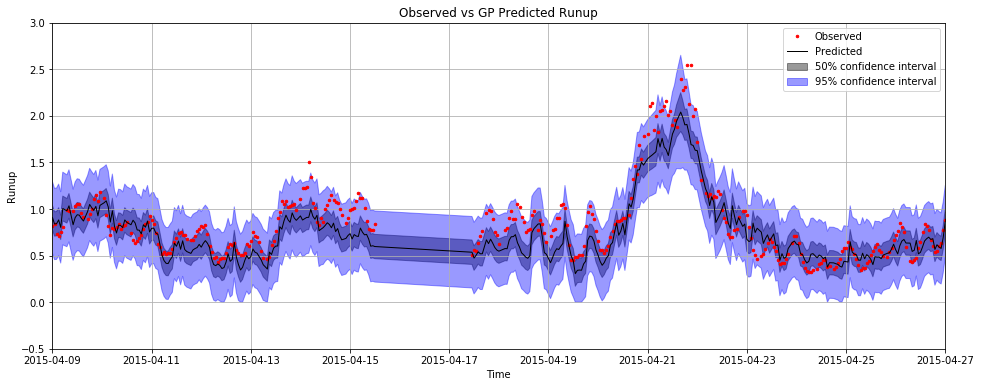

In [10]:
# Create a df for use in plotting
df_y = pd.DataFrame({'runup':y_test['runup'].values,'runup_pred':y_pred.ravel(),'sigma':sigma},index=y_test.index)
df_y.sort_index(inplace=True) # Time order
# Plot
fig, axes = plt.subplots(figsize=(16,6))
axes.plot(df_y['runup'],'r.',markersize=5,label='Observed')
axes.plot(df_y['runup_pred'],'k-',lw=1,label='Predicted')
axes.fill_between(df_y.index,
                  (df_y['runup_pred'] - 0.67 * df_y['sigma']).clip(0),
                  df_y['runup_pred'] + 0.67 * df_y['sigma'],
                  alpha=0.4, color='k', label='50% confidence interval')
axes.fill_between(df_y.index,
                  (df_y['runup_pred'] - 1.9600 * df_y['sigma']).clip(0),
                  df_y['runup_pred'] + 1.9600 * df_y['sigma'],
                  alpha=0.4, color='b', label='95% confidence interval')
axes.set_ylabel('Runup')
axes.set_xlabel('Time')
axes.set_title('Observed vs GP Predicted Runup')
axes.legend(loc='upper right')
axes.grid(True)
axes.set_xlim('2015-04-09','2015-04-27')
axes.set_ylim(-0.5,3);